### Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Enable LaTeX formatting
plt.rcParams['text.usetex'] = True

import lgbloch.viz as viz
from lgbloch.engine import distributions_from_deltas, distributions_from_times
from lgbloch.lgi import (
    entropic_LGI,
    standard_LGI_dichotomic_three_point,
    wigner_LGI_dichotomic_three_point,
    standard_LGI_dichotomic_four_point,
    wigner_LGI_dichotomic_four_point,
 )

# Initialize global engine state `current_engine` similar to lgbloch.engine._get_engine_env
from lgbloch.engine import spin_ops, projectors_Jz
from bloch4spin.basis import bloch_init
from bloch4spin.evolution import GeneralizedBlochEvolutionMatrix, GeneralizedBlochState
from bloch4spin.observable import GeneralizedBlochObservable

### Parallelism and Performance Note
- Grid evaluation (`plot_boolean_region`) in `viz` supports parallelism: you can explicitly pass `n_jobs` (e.g., `n_jobs=8`) to speed up calculation. However, please note that the global state of `bloch4spin` (such as `bloch_init(d)`) may have race conditions under multi-threading, so be cautious when simulating mixed dimensions.
- Curve plotting (`plot_multioutput_curves`) is executed serially to ensure stability in complex environments.
- Probability distribution calculations strictly adopt "intrusive" semantics: each subset is calculated independently, and marginal distributions are never used for summation.

### Spin-1/2 System

In [5]:
# Choose Hilbert-space dimension
_d = 2
bloch_init(_d)
Jx, Jy, Jz, Jp, Jm = spin_ops(_d)
L_H_mat = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Jy)
L_K_mat = GeneralizedBlochEvolutionMatrix.from_Lindblad(Jm)
rho0 = np.eye(_d, dtype=complex) / _d
r0 = GeneralizedBlochState.from_matrix(rho0)
obs_list = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(_d)]

# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat,
    "r0": r0,
    "obs_list": obs_list,
}
ATOL = 1e-10

# All helper functions now fetch engine state (L, r0, obs_list) from `current_engine`.

def _engine_kwargs():
    e = current_engine
    return dict(d=e["d"], L_mat=e["L_mat"], r0=e["r0"], obs_list=e["obs_list"])

def bool_LG_three_point(t12, t23):
    deltas = (t12, t23)
    jps = distributions_from_deltas(deltas, **_engine_kwargs())
    e_min = entropic_LGI(3, jps)
    s_min = standard_LGI_dichotomic_three_point(jps)
    w_min = wigner_LGI_dichotomic_three_point(jps)
    return [e_min < -ATOL, s_min < -ATOL, w_min < -ATOL]

In [ ]:
# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.03 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}

t12_range = (0.0, 4 * np.pi)
t23_range = (0.0, 4 * np.pi)

# Plot overlay and separate figures in one call (mode='both')
fig_overlay, ax_overlay, separate_figs = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (110/255, 106/255, 192/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='both',
    save_data="data/3-point-LGIs-a-1000.npz"
)
ax_overlay.set_xlabel(r'Rotation Angle $\beta_{12}=\omega\Delta t_{12}$')
ax_overlay.set_ylabel(r'Rotation Angle $\beta_{23}=\omega\Delta t_{23}$')

# Figure panel annotation (a)
ax_overlay.text(0.05, 0.95, r'{\bfseries a}\quad$\gamma=0.03\omega$', transform=ax_overlay.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
# Save overlay figure
fig_overlay.savefig('3-point-LGIs-a.png', dpi=300, bbox_inches='tight')

Parallel execution: 21 chunks (target 20) on 5 workers.
Progress: 5/21 chunks

In [ ]:
# Global engine dict used by helper functions above
current_engine = {
    "d": _d,
    "L_mat": L_H_mat + 0.08 * L_K_mat,
    "r0": r0 + 0.0 * Jz,
    "obs_list": obs_list,
}

t12_range = (0.0, 4 * np.pi)
t23_range = (0.0, 4 * np.pi)

# Plot overlay and separate figures in one call (mode='both')
fig_overlay, ax_overlay, separate_figs = viz.plot_boolean_region(
    bool_LG_three_point,
    t12_range,
    t23_range,
    n=1000,
    label=[r'Entropic LGI', r'Standard LGI', r'Wigner LGI'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255), (110/255, 106/255, 192/255)],
    alpha=[0.45, 0.35, 0.40],
    linestyle=['-.', '--', ':'],
    linewidth=[1.8, 1.5, 1.2],
    mode='both',
    save_data="data/3-point-LGIs-b-1000.npz"
)
ax_overlay.set_xlabel(r'Rotation Angle $\beta_{12}=\omega\Delta t_{12}$')
ax_overlay.set_ylabel(r'Rotation Angle $\beta_{23}=\omega\Delta t_{23}$')

# Figure panel annotation (a)
ax_overlay.text(0.05, 0.95, r'{\bfseries b}\quad$\gamma=0.08\omega$', transform=ax_overlay.transAxes,
                fontsize=18, verticalalignment='top', horizontalalignment='left')
# Save overlay figure
fig_overlay.savefig('3-point-LGIs-b.png', dpi=300, bbox_inches='tight')

### Three Level Lambda System

### Operator Representations

**1. Spin-1 System ($d=3$)**
Basis mapping: $|E_1\rangle \leftrightarrow |+1\rangle$, $|E_2\rangle \leftrightarrow |0\rangle$, $|E_3\rangle \leftrightarrow |-1\rangle$.
The Hamiltonian $H = \sum E_i |E_i\rangle\langle E_i| + (\omega_{12}|0\rangle\langle 1| + \text{h.c.}) + (\omega_{23}|-1\rangle\langle 0| + \text{h.c.})$ can be expressed using spin-1 operators $J_z, J_\pm$:
- Diagonal terms:
  $|1\rangle\langle 1| = \frac{J_z(1+J_z)}{2}, \quad |0\rangle\langle 0| = 1-J_z^2, \quad |-1\rangle\langle -1| = \frac{J_z(J_z-1)}{2}$
- Coupling terms:
  $|0\rangle\langle 1| = \frac{1}{\sqrt{2}} J_- J_z, \quad |-1\rangle\langle 0| = \frac{1}{\sqrt{2}} J_- (1-J_z)$

**2. Spin-1/2 Effective System ($d=2$)**
Basis mapping: $|E_1\rangle \leftrightarrow |+1/2\rangle$, $|E_2\rangle \leftrightarrow |-1/2\rangle$.
Treating $|E_3\rangle$ as an environment inducing decay from $|E_2\rangle \to |E_1\rangle$:
- Hamiltonian ($1 \leftrightarrow 2$ subspace):
  $H_{\text{eff}} = \frac{E_1+E_2}{2} + (E_1-E_2)J_z + (\omega_{12} J_- + \omega_{12}^* J_+)$
- Lindblad Operator (Decay $|E_2\rangle \to |E_1\rangle$):
  $L = \sqrt{\gamma} |E_1\rangle\langle E_2| = \sqrt{\gamma} J_+$
  where $\gamma \approx |\omega_{23}|$ (using initial coupling strength as rate approximation).

In [ ]:
# We need strong mixing between levels to see LGI violations.
# Set E1 approx E2 and omega_12 comparable or larger.
E_1 = 0.0
E_2 = 1.0
E_3 = 0.1
omega_12 = 0.5
omega_23 = 0.002  # Coupling to "environment"

# --- 1. Spin-1 System (Full 3-level) ---
bloch_init(3)
Ham_3 = np.array([[E_1,               omega_12,          0.0],
                  [np.conj(omega_12), E_2,               omega_23],
                  [0.0,               np.conj(omega_23), E_3]], dtype=complex)

L_mat_3 = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Ham_3)

# Initial State: Pure State |+1> (Index 0)
rho0_3 = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
r0_3 = GeneralizedBlochState.from_matrix(rho0_3)

# Measure only |+1> (index 0) and |0> (index 1)
obs_list_3 = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(3, indices=(0, 1))]

# --- 2. Spin-1/2 System (Effective 2-level with decay) ---
bloch_init(2)
Ham_2 = np.array([[E_1, omega_12],
                  [np.conj(omega_12), E_2]], dtype=complex)

# Lindblad: Decay from E2 to E1 induced by E3 coupling
gamma = np.abs(omega_23)
L_opr_2 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)

L_mat_H_2 = GeneralizedBlochEvolutionMatrix.from_Hamiltonian(Ham_2)
L_mat_L_2 = GeneralizedBlochEvolutionMatrix.from_Lindblad(L_opr_2)
L_mat_2 = L_mat_H_2 + L_mat_L_2

# Initial State: Pure State |+1/2> (Index 0)
rho0_2 = np.array([[1.0, 0.0], [0.0, 0.0]])
r0_2 = GeneralizedBlochState.from_matrix(rho0_2)
obs_list_2 = [GeneralizedBlochObservable.from_projector(P) for P in projectors_Jz(2)]

# --- Simulation & Plotting ---
def calc_specific_elgi(jps):
    # D_{1,3} = H(Q1,Q2) + H(Q2,Q3) - H(Q1,Q2,Q3) - H(Q2)
    # This is Conditional Mutual Information I(Q1; Q3 | Q2)
    dist = jps.distributions
    from lgbloch.lgi import _shannon_entropy_bits
    h12 = _shannon_entropy_bits(dist[(1, 2)])
    h23 = _shannon_entropy_bits(dist[(2, 3)])
    h123 = _shannon_entropy_bits(dist[(1, 2, 3)])
    h2 = _shannon_entropy_bits(dist[(2,)])
    return h12 + h23 - h123 - h2

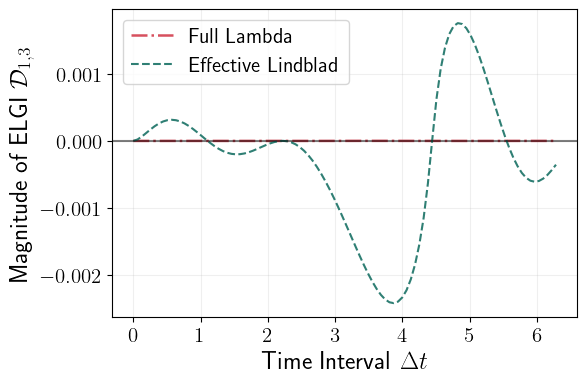

In [4]:
# Add a start time offset to ensure the state evolves into a superposition 
# before the first measurement.
# Rabi frequency approx 2*omega_12. Max superposition at t ~ pi/(4*omega_12).
t_start = np.pi / (4 * omega_12) 

def evaluate_lgi(dt):
    # Times: t1, t2, t3
    times = [t_start, t_start + dt, t_start + 2*dt]
    
    # Spin-1
    bloch_init(3)
    jps_3 = distributions_from_times(times, d=3, L_mat=L_mat_3, r0=r0_3, obs_list=obs_list_3)
    val_3 = calc_specific_elgi(jps_3)
    
    # Spin-1/2
    bloch_init(2)
    jps_2 = distributions_from_times(times, d=2, L_mat=L_mat_2, r0=r0_2, obs_list=obs_list_2)
    val_2 = calc_specific_elgi(jps_2)
    
    return [val_3, val_2]

delta_ts = np.linspace(0, 2 * np.pi, 100)

fig, ax = viz.plot_multioutput_curves(
    evaluate_lgi,
    delta_ts,
    label=['Full Lambda', 'Effective Lindblad'],
    color=[(215/255, 80/255, 94/255), (47/255, 127/255, 116/255)],
    linewidth=[1.8, 1.5],
    linestyle=['-.', '--']
)
ax.set_xlabel(r'Time Interval $\Delta t$')
ax.set_ylabel(r'Magnitude of ELGI $\mathcal{D}_{1,3}$')
ax.legend(loc='upper left', fontsize=15)

# Add reference line
ax.axhline(0, color='k', linestyle='-', alpha=0.5)

fig.savefig('non-Markovian.png', dpi=300, bbox_inches='tight')